In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from verstack import NaNImputer 
import numpy as np 
from sklearn.metrics import confusion_matrix

e:\ArcGIS\ACI Center\Data analysis\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df=pd.read_csv('E:\ArcGIS\ACI Center\Data analysis\SparePartsSales_1Year.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584619 entries, 0 to 1584618
Data columns (total 27 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   PageNo              1584619 non-null  int64 
 1   SL                  1584619 non-null  int64 
 2   Invoice_Id          1584619 non-null  int64 
 3   InvoiceNo           1584619 non-null  object
 4   Invoice_Date        1584619 non-null  object
 5   Dealer_Code         1584619 non-null  object
 6   Dealer_Name         1584619 non-null  object
 7   Customer_Type       1584619 non-null  object
 8   Customer_Name       1584587 non-null  object
 9   Address             137601 non-null   object
 10  Mobile              789701 non-null   object
 11  Job_Card_No         1584619 non-null  object
 12  Job_Type            1133725 non-null  object
 13  Job_Type_Details    295331 non-null   object
 14  Product_Code        1584619 non-null  object
 15  Product_Name        1584619 non-

In [3]:
# Filter rows where Selling Price and Discount are not negative
clean_df = df[(df['SellingPrice'] >= 0) & (df['Discount'] >= 0)]

clean_df.info()
df=clean_df


<class 'pandas.core.frame.DataFrame'>
Index: 1584388 entries, 0 to 1584618
Data columns (total 27 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   PageNo              1584388 non-null  int64 
 1   SL                  1584388 non-null  int64 
 2   Invoice_Id          1584388 non-null  int64 
 3   InvoiceNo           1584388 non-null  object
 4   Invoice_Date        1584388 non-null  object
 5   Dealer_Code         1584388 non-null  object
 6   Dealer_Name         1584388 non-null  object
 7   Customer_Type       1584388 non-null  object
 8   Customer_Name       1584358 non-null  object
 9   Address             137565 non-null   object
 10  Mobile              789574 non-null   object
 11  Job_Card_No         1584388 non-null  object
 12  Job_Type            1133654 non-null  object
 13  Job_Type_Details    295316 non-null   object
 14  Product_Code        1584388 non-null  object
 15  Product_Name        1584388 non-null 

In [23]:
# Group by 'Product_Name' and aggregate 'Product_Code' using apply
result = df.groupby('Product_Name').apply(
    lambda group: pd.Series({
        'Product_Codes': ', '.join(group['Product_Code'].unique()),  # Join unique product codes
        'Product_Code_Count': group['Product_Code'].nunique()       # Count unique product codes
    })
).reset_index()

# Rename columns for clarity
result.columns = ['Product_Name', 'Product_Codes', 'Product_Code_Count']

# Sort the DataFrame by 'Product_Code_Count' in descending order
result_sorted = result.sort_values(by='Product_Code_Count', ascending=False).reset_index(drop=True)

# Display the sorted result
print(result_sorted)


                 Product_Name  \
0                     BEARING   
1                BOLT, FLANGE   
2                        BOLT   
3                      COLLAR   
4           TANK SIDE COVER 2   
...                       ...   
2347      COVER, HANDLE FRONT   
2348       COVER, HANDLE LEVE   
2349  ASSIST GRIP ASSY.,-MBL2   
2350      COVER, HANDLE UPPER   
2351  Yamalube Sporty Premium   

                                          Product_Codes  Product_Code_Count  
0     PE46, PW34, P241, PJ21, P243, PBKF, P244, PM73...                  59  
1     PN28, P251, P104, P171, PR22, P252, P250, Y110...                  57  
2     PBIU, P173, P229, P174, PCHO, PR37, P348, PJ13...                  39  
3     PT15, P208, P203, P205, P308, P207, P842, P200...                  33  
4     Y184, Y186, YE88, YE89, Y182, PS59, Y183, YE90...                  29  
...                                                 ...                 ...  
2347                                               Y032  

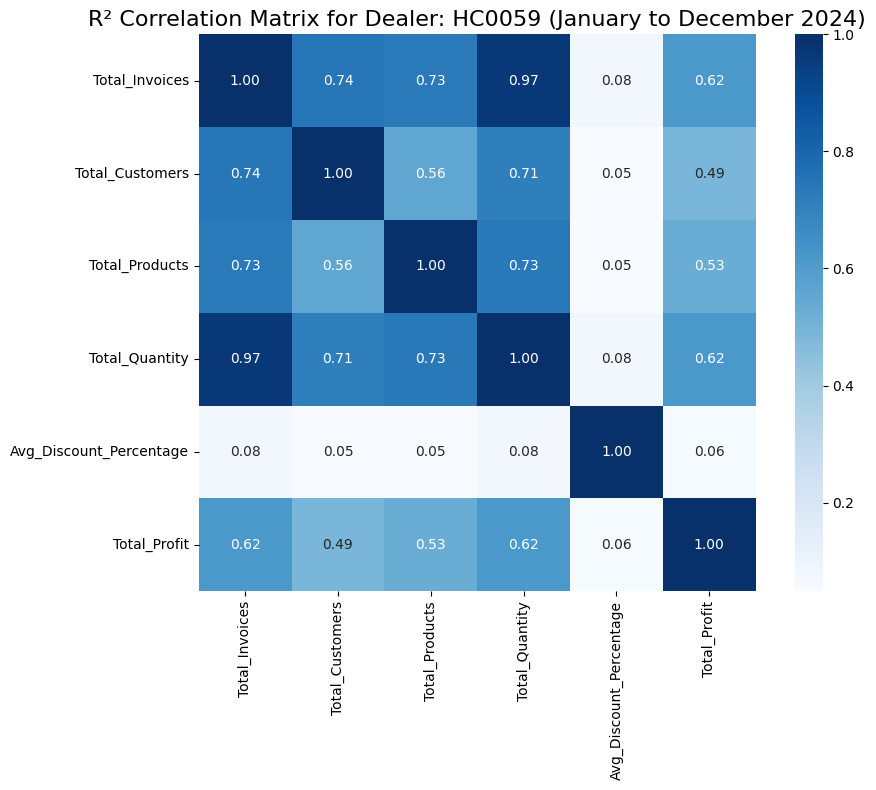

In [4]:
# Ensure the Invoice_Date column is in datetime format
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'])

# Add a column for 7-day periods
df['7_Day_Period'] = df['Invoice_Date'].dt.to_period('7D')

# Function to calculate discount percentage
def calculate_discount_percentage(row):
    return (row['Discount'] / (row['Discount'] + row['Buying_Price'])) * 100 if (row['Discount'] + row['Buying_Price']) > 0 else 0

df['Discount_Percentage'] = df.apply(calculate_discount_percentage, axis=1)

# Function to analyze and compute correlation matrix for a specific dealer
def analyze_dealer_correlation_matrix(dealer_code):
    # Step 1: Filter data for the given dealer
    dealer_data = df[df['Dealer_Code'] == dealer_code]

    if dealer_data.empty:
        print(f"No data found for Dealer Code: {dealer_code}")
        return

    # Step 2: Aggregate data by 7-day periods
    aggregated_data = dealer_data.groupby('7_Day_Period').agg(
        Total_Invoices=('InvoiceNo', 'count'),  # Total invoice count
        Total_Customers=('Customer_Name', 'nunique'),  # Unique customer count
        Total_Products=('Product_Name', 'nunique'),  # Unique product count
        Total_Quantity=('Quantity', 'sum'),  # Total quantity
        Avg_Discount_Percentage=('Discount_Percentage', 'mean'),  # Average discount percentage
        Total_Profit=('Total_Profit', 'sum')  # Total profit summation
    ).reset_index()

    # Exclude non-numeric columns (like '7_Day_Period') from correlation computation
    numeric_data = aggregated_data.drop(columns=['7_Day_Period'])

    # Step 3: Compute correlation matrix (R² values)
    correlation_matrix = numeric_data.corr() ** 2

    # Step 4: Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f', cbar=True, square=True,
                xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)
    plt.title(f'R² Correlation Matrix for Dealer: {dealer_code} (January to December 2024)', fontsize=16)
    plt.tight_layout()
    plt.show()

# Input dealer code for analysis
dealer_code_input = input("Enter Dealer Code: ")
analyze_dealer_correlation_matrix(dealer_code_input)



Rank of product according to total loss


Top 10 Products by Loss Percentage (Counter Sales):
           Product_Name  Counter_Sales_Count  Avg_Discount_Percentage  \
1638         PIN, SPLIT                   18                 0.000000   
1629        PIN, COTTER                    1                 0.000000   
22      .SCREW, FITTING                    2                 0.000000   
1640          PIN-SPLIT                    5                 0.000000   
1848  SCREW WITH WASHER                   15                 0.000000   
1947   SPLIT COTTER PIN                    7                 0.000000   
236           CAP, BOLT                   45                 0.952381   
1855    SCREW, PAN HEAD                  166                 2.086695   
52                 BALL                  147                 2.482993   
1524     OIL SEAL (RXS)                    1                 0.000000   

      Avg_Loss_Percentage  
1638           794.444444  
1629           700.000000  
22             550.000000  
1640           468.000000  
184

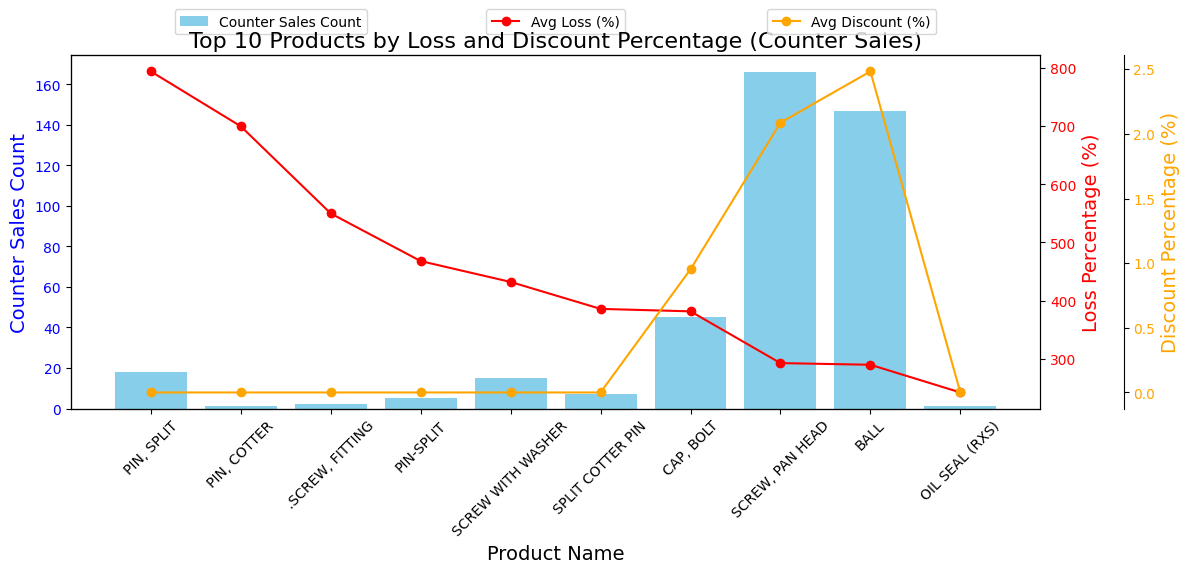

In [5]:
# Ensure the Invoice_Date column is in datetime format
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'])

# Function to calculate discount percentage
def calculate_discount_percentage(row):
    return (row['Discount'] / (row['Discount'] + row['Buying_Price'])) * 100 if (row['Discount'] + row['Buying_Price']) > 0 else 0

# Function to calculate loss percentage
def calculate_loss_percentage(row):
    return (row['Total_Profit'] / row['Buying_Price']) * 100 if row['Buying_Price'] > 0 else 0

# Apply discount and loss percentage calculations
df['Discount_Percentage'] = df.apply(calculate_discount_percentage, axis=1)
df['Loss_Percentage'] = df.apply(calculate_loss_percentage, axis=1)

# Filter for Counter Sales
counter_sales_data = df[df['Job_Card_No'] == 'Counter Sales']

# Group by Product Name and calculate required metrics
aggregated_data = counter_sales_data.groupby('Product_Name').agg(
    Counter_Sales_Count=('Job_Card_No', 'count'),
    Avg_Discount_Percentage=('Discount_Percentage', 'mean'),
    Avg_Loss_Percentage=('Loss_Percentage', 'mean')
).reset_index()

# Sort by Average Loss Percentage (highest to lowest)
sorted_data = aggregated_data.sort_values(by='Avg_Loss_Percentage', ascending=False)

# Select the top 10 products
top_10_products = sorted_data.head(10)

# Display the top 10 results in the terminal
print("\nTop 10 Products by Loss Percentage (Counter Sales):")
print(top_10_products)

# Plot a three-axis bar chart
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for Counter Sales Count
ax1.bar(top_10_products['Product_Name'], top_10_products['Counter_Sales_Count'], color='skyblue', label='Counter Sales Count')
ax1.set_xlabel('Product Name', fontsize=14)
ax1.set_ylabel('Counter Sales Count', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.tick_params(axis='x', rotation=45)

# Secondary Y-axis for Loss Percentage
ax2 = ax1.twinx()
ax2.plot(top_10_products['Product_Name'], top_10_products['Avg_Loss_Percentage'], color='red', marker='o', label='Avg Loss (%)')
ax2.set_ylabel('Loss Percentage (%)', fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Third Y-axis for Discount Percentage
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Offset the third axis
ax3.plot(top_10_products['Product_Name'], top_10_products['Avg_Discount_Percentage'], color='orange', marker='o', label='Avg Discount (%)')
ax3.set_ylabel('Discount Percentage (%)', fontsize=14, color='orange')
ax3.tick_params(axis='y', labelcolor='orange')

# Add legends for all axes
ax1.legend(loc='upper left', bbox_to_anchor=(0.1, 1.15), fontsize=10)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=10)
ax3.legend(loc='upper right', bbox_to_anchor=(0.9, 1.15), fontsize=10)

# Add a title
plt.title('Top 10 Products by Loss and Discount Percentage (Counter Sales)', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()


Processing Group 1...


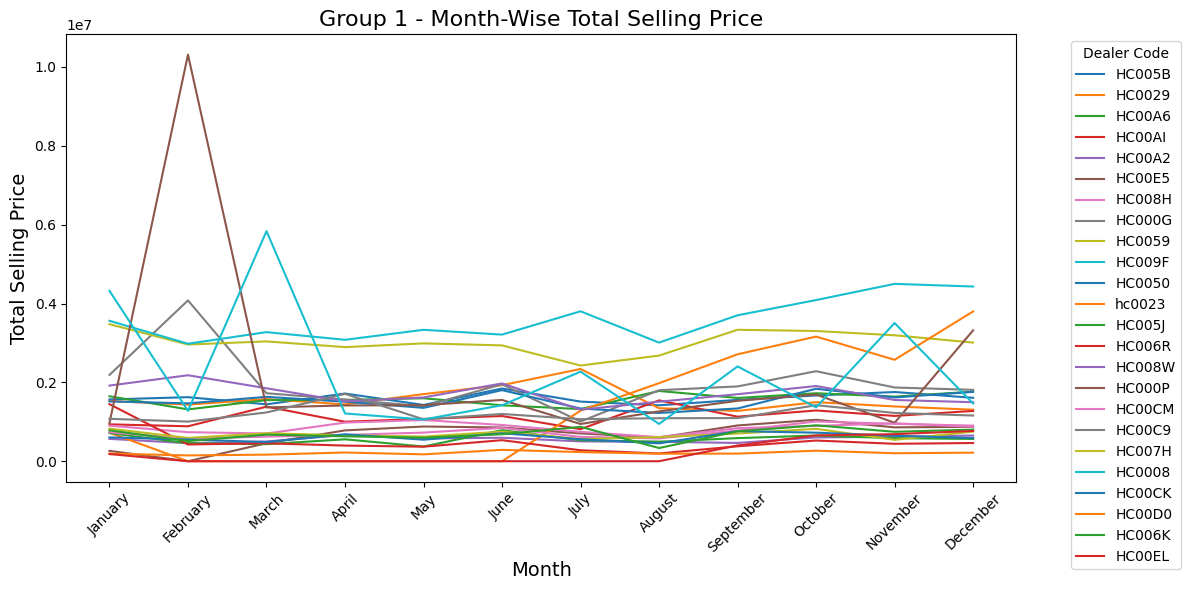

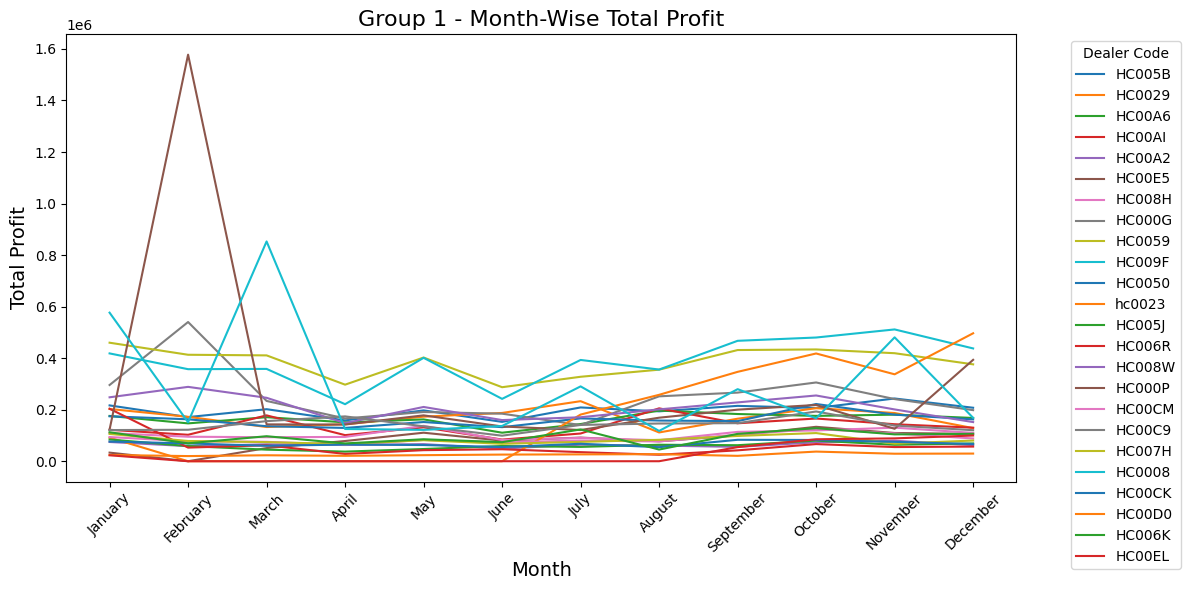

Processing Group 2...


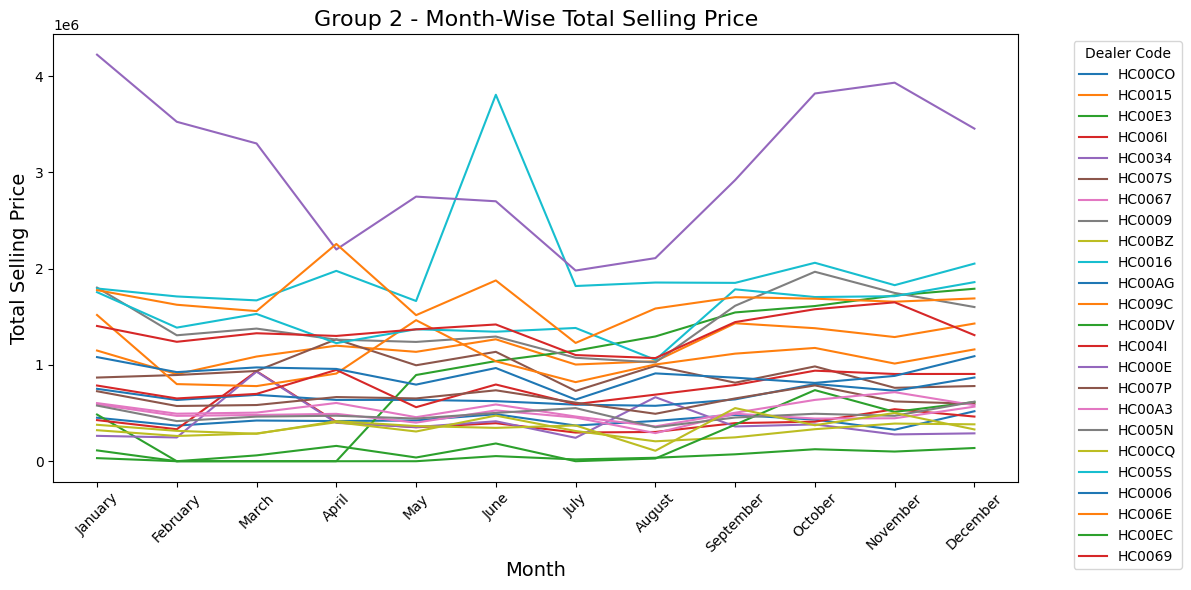

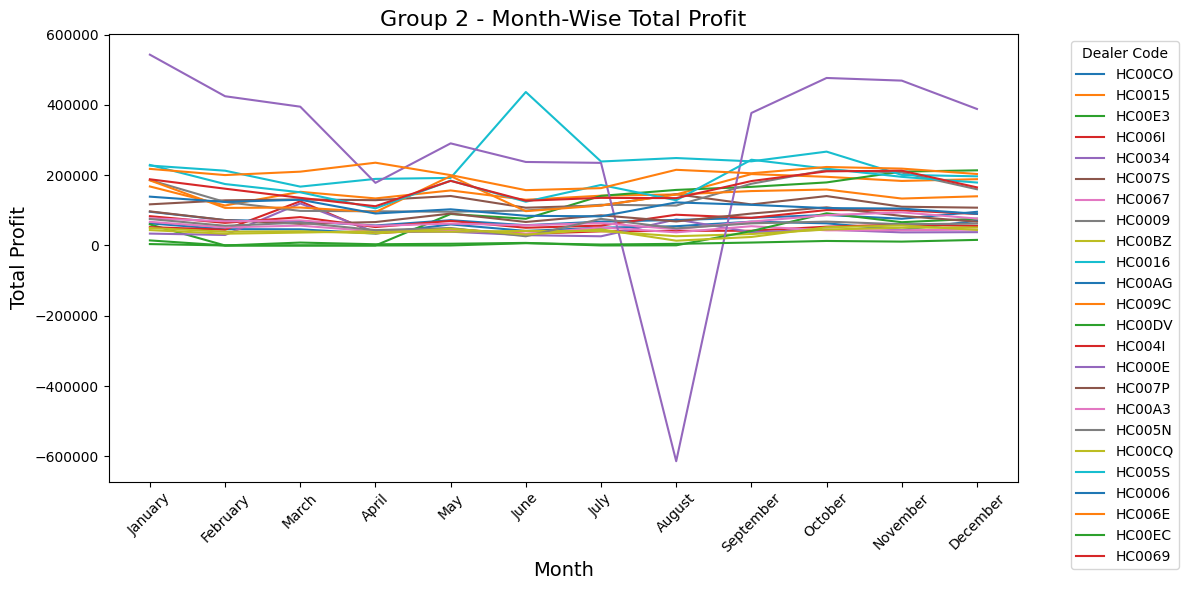

Processing Group 3...


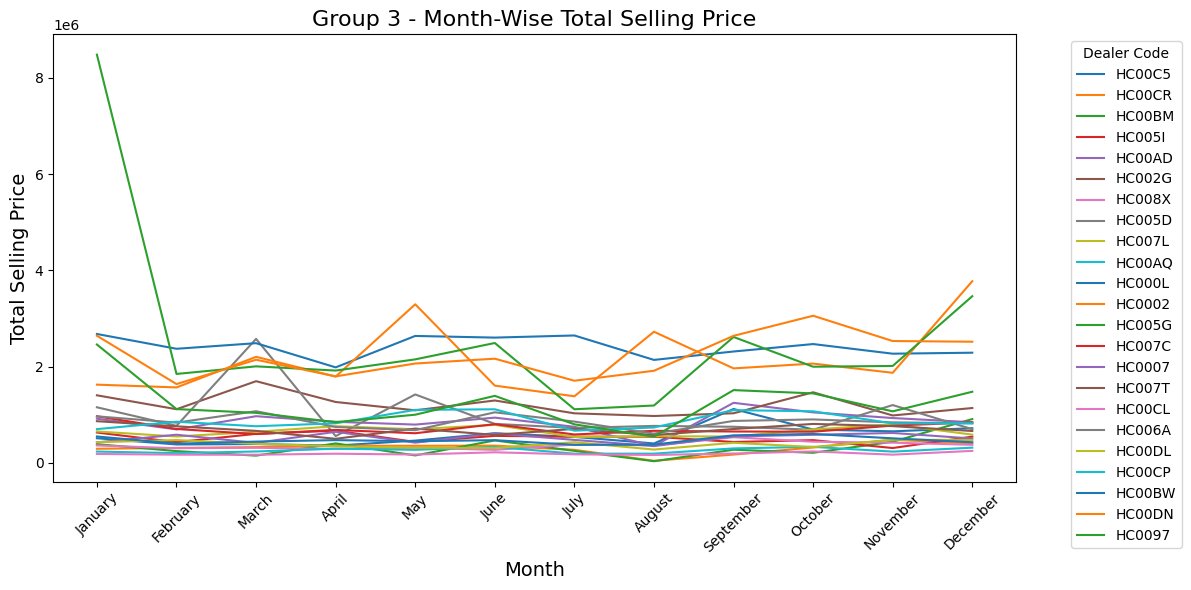

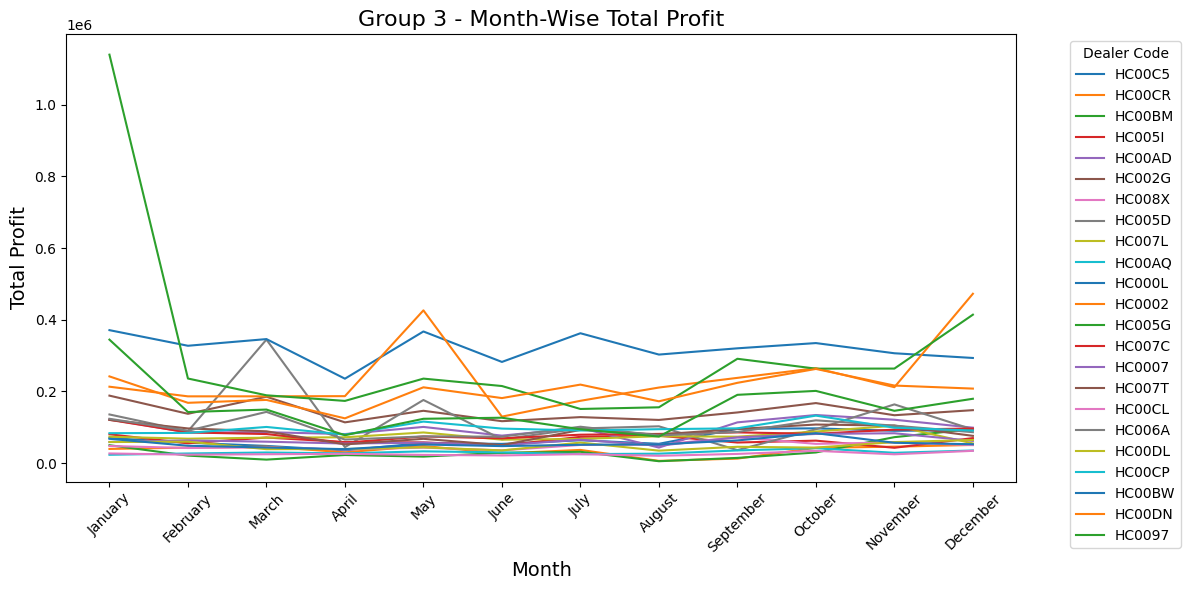

Processing Group 4...


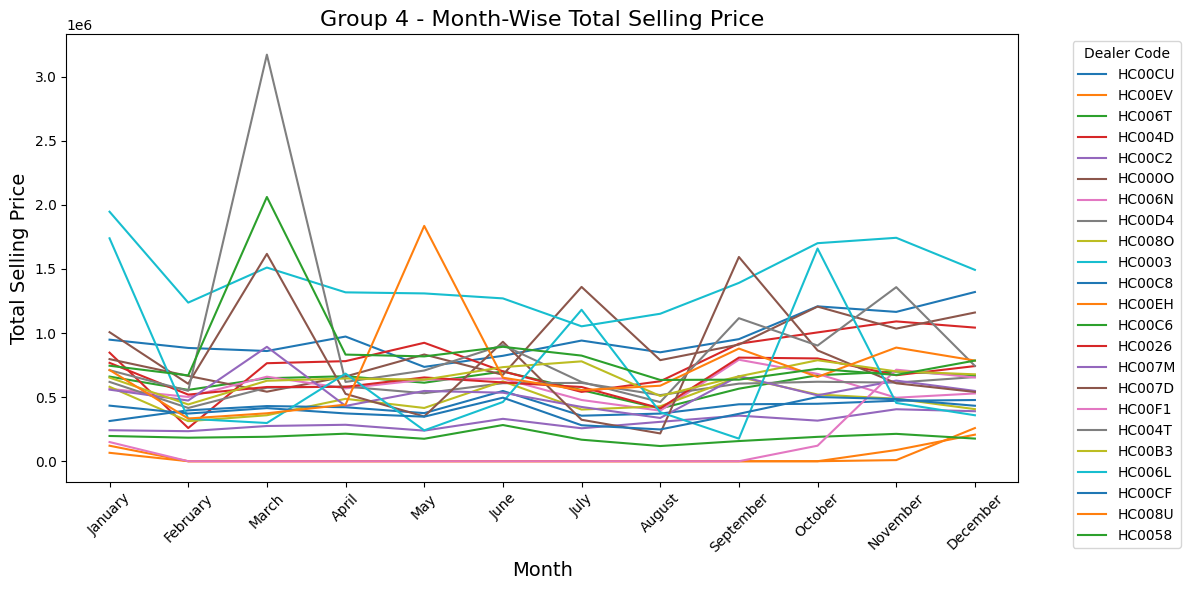

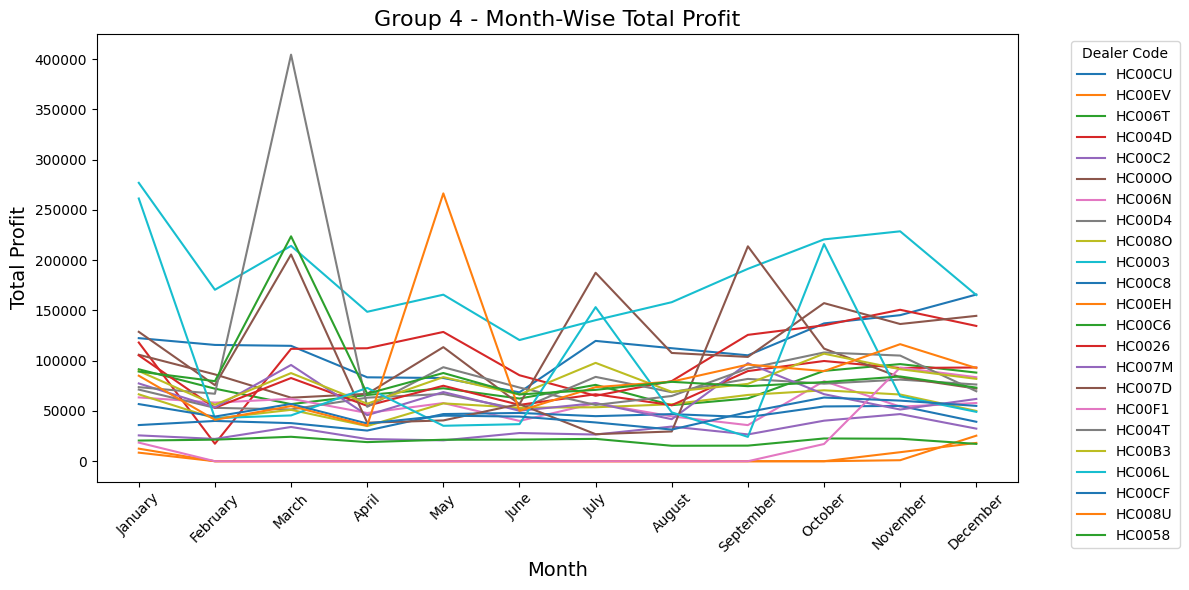

Processing Group 5...


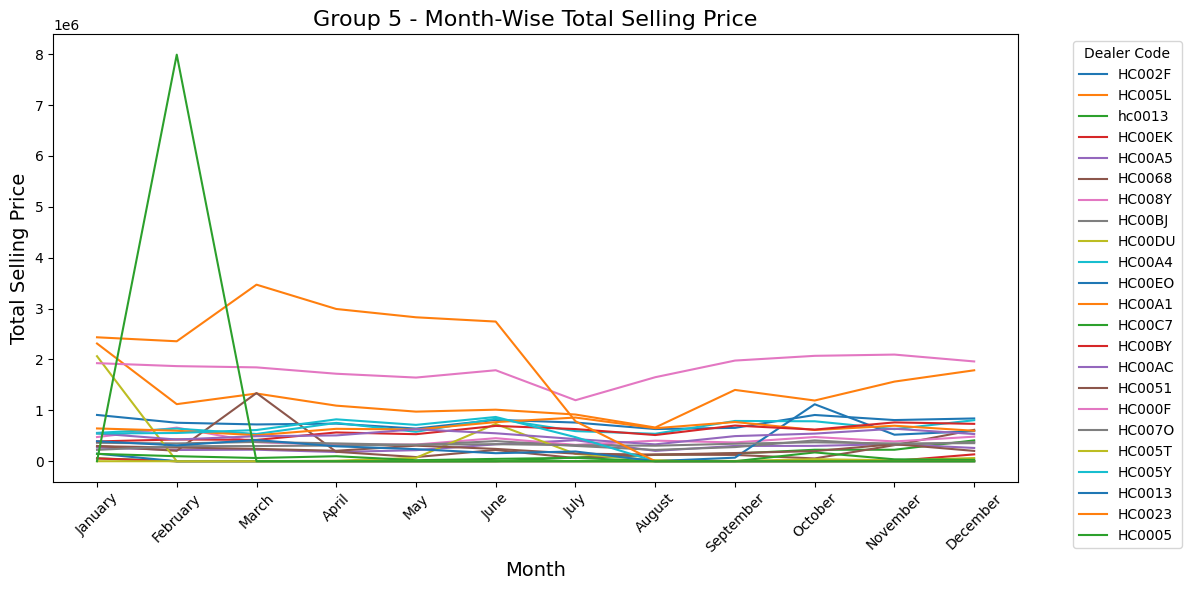

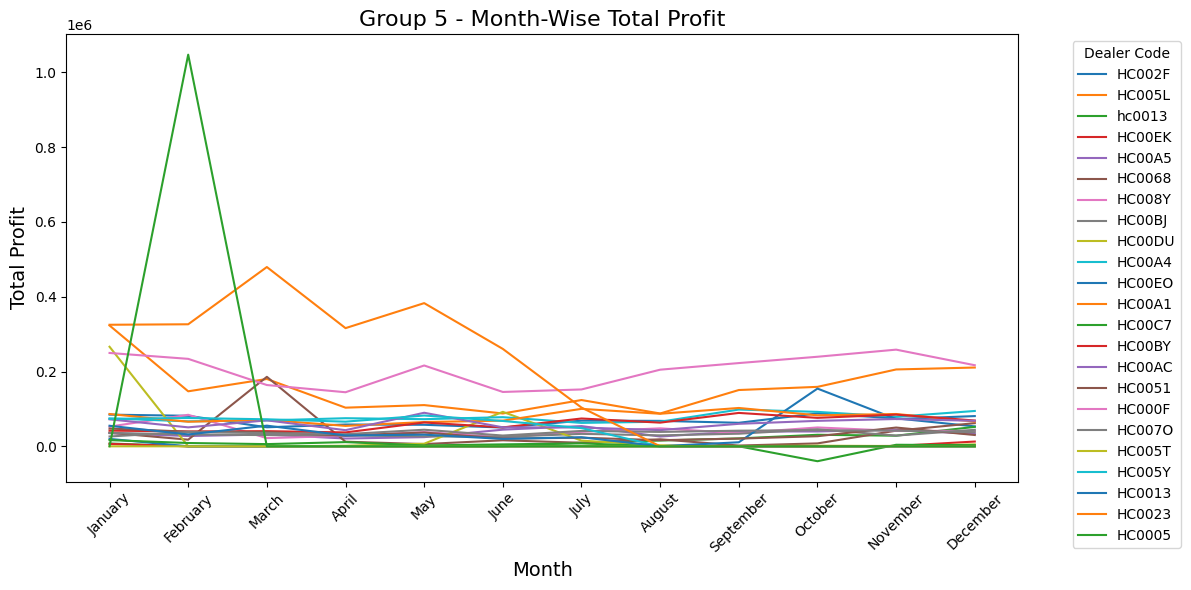

In [6]:
# Ensure Invoice_Date is in datetime format
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'])

# Extract month name from Invoice_Date
df['Month'] = df['Invoice_Date'].dt.strftime('%B')

# Define month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

# Get the unique dealer codes
dealer_codes = df['Dealer_Code'].unique()

# Divide the dealer codes into 5 groups
grouped_dealer_codes = np.array_split(dealer_codes, 5)

# Function to plot graphs for a single group
def plot_group_graphs(dealer_group, group_number):
    # Filter data for the dealers in this group
    group_data = df[df['Dealer_Code'].isin(dealer_group)]

    # Calculate total selling price and profit by month for each dealer
    selling_price_data = group_data.groupby(['Dealer_Code', 'Month'])['SellingPriceTotal'].sum().reset_index()
    profit_data = group_data.groupby(['Dealer_Code', 'Month'])['Total_Profit'].sum().reset_index()

    # Plot total selling price graph
    plt.figure(figsize=(12, 6))
    for dealer_code in dealer_group:
        dealer_selling_data = selling_price_data[selling_price_data['Dealer_Code'] == dealer_code]
        plt.plot(dealer_selling_data['Month'], dealer_selling_data['SellingPriceTotal'], label=dealer_code)
    plt.title(f'Group {group_number} - Month-Wise Total Selling Price', fontsize=16)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Total Selling Price', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title='Dealer Code', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Plot total profit graph
    plt.figure(figsize=(12, 6))
    for dealer_code in dealer_group:
        dealer_profit_data = profit_data[profit_data['Dealer_Code'] == dealer_code]
        plt.plot(dealer_profit_data['Month'], dealer_profit_data['Total_Profit'], label=dealer_code)
    plt.title(f'Group {group_number} - Month-Wise Total Profit', fontsize=16)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Total Profit', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title='Dealer Code', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Loop through each group and plot graphs
for group_number, dealer_group in enumerate(grouped_dealer_codes, start=1):
    print(f"Processing Group {group_number}...")
    plot_group_graphs(dealer_group, group_number)



Month-Wise Loss Percentage Comparison (With and Without Discount Condition)

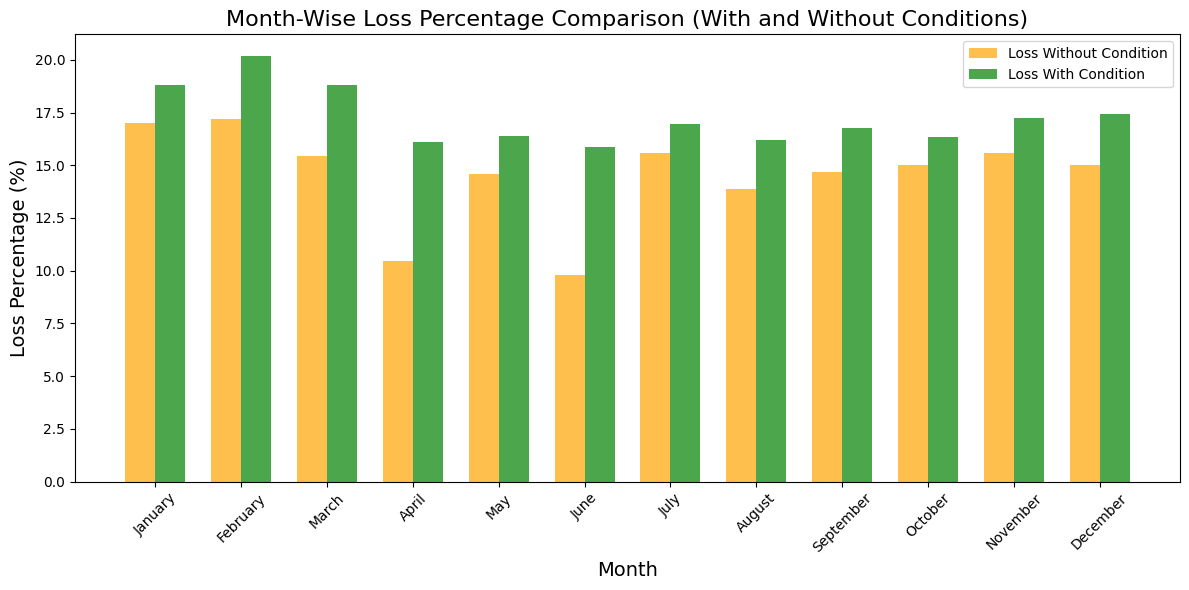


Month-Wise Loss Percentage Comparison:
        Month  Loss_Without_Condition  Loss_With_Condition
0     January               17.024380            18.822934
1    February               17.183161            20.197810
2       March               15.423314            18.782306
3       April               10.467278            16.081037
4         May               14.605973            16.380250
5        June                9.817687            15.871713
6        July               15.584264            16.953494
7      August               13.859868            16.219899
8   September               14.679249            16.760261
9     October               15.003828            16.353650
10   November               15.564405            17.260362
11   December               15.017254            17.447038


In [7]:
# Ensure Invoice_Date is in datetime format
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'])

# Extract month names
df['Month'] = df['Invoice_Date'].dt.strftime('%B')

# Define the month order for sorting
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

# Calculate discount percentage
def calculate_discount_percentage(row):
    return (row['Discount'] / (row['Discount'] + row['Buying_Price'])) * 100 if (row['Discount'] + row['Buying_Price']) > 0 else 0

# Calculate loss percentage
def calculate_loss_percentage(row):
    return (row['Total_Profit'] / row['Buying_Price']) * 100 if row['Buying_Price'] > 0 else 0

# Apply calculations
df['Discount_Percentage'] = df.apply(calculate_discount_percentage, axis=1)
df['Loss_Percentage'] = df.apply(calculate_loss_percentage, axis=1)

# Month-wise analysis
results = []

for month in month_order:
    # Filter data for the current month
    month_data = df[df['Month'] == month]
    
    if month_data.empty:
        continue

    # Total loss percentage without condition
    total_loss_without_condition = (month_data['Total_Profit'].sum() / month_data['Buying_Price'].sum()) * 100

    # Apply Condition 1: Exclude products with an average discount percentage above 5%
    condition_1_data = month_data[month_data['Discount_Percentage'] <= 5]

    # Total loss percentage with condition
    total_loss_with_condition = (condition_1_data['Total_Profit'].sum() / condition_1_data['Buying_Price'].sum()) * 100 if not condition_1_data.empty else 0

    # Store results
    results.append({
        'Month': month,
        'Loss_Without_Condition': total_loss_without_condition,
        'Loss_With_Condition': total_loss_with_condition
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Plot the comparison
x = np.arange(len(results_df['Month']))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Bar for Loss Without Condition
rects1 = ax.bar(x - width/2, results_df['Loss_Without_Condition'], width, label='Loss Without Condition', color='orange', alpha=0.7)

# Bar for Loss With Condition
rects2 = ax.bar(x + width/2, results_df['Loss_With_Condition'], width, label='Loss With Condition', color='green', alpha=0.7)

# Add titles and labels
ax.set_title('Month-Wise Loss Percentage Comparison (With and Without Conditions)', fontsize=16)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Loss Percentage (%)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(results_df['Month'], rotation=45)
ax.legend()

# Layout adjustments
plt.tight_layout()

# Show the plot
plt.show()

# Print results in the terminal
print("\nMonth-Wise Loss Percentage Comparison:")
print(results_df)


Month-Wise Reduction in Loss Percentage After Applying Discount Condition

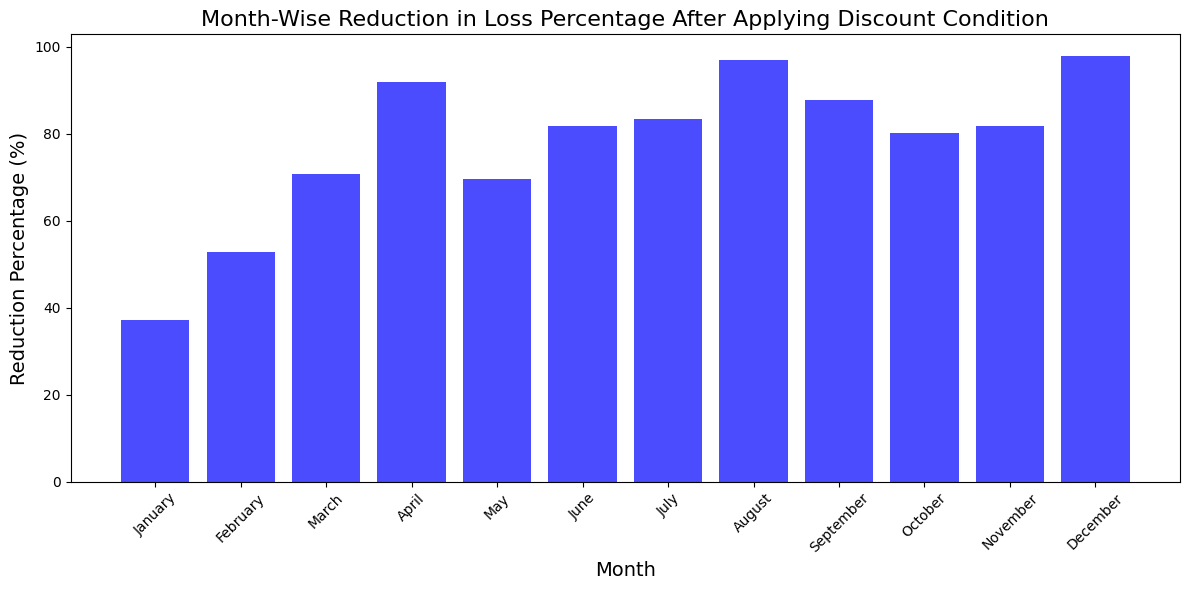


Month-Wise Reduction Percentage:
        Month  Reduction_Percentage
0     January             37.089806
1    February             52.723889
2       March             70.782239
3       April             91.877960
4         May             69.577027
5        June             81.906031
6        July             83.497936
7      August             96.901070
8   September             87.687098
9     October             80.144691
10   November             81.704548
11   December             97.989561


In [18]:
# Ensure Invoice_Date is in datetime format
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'])

# Extract month names
df['Month'] = df['Invoice_Date'].dt.strftime('%B')

# Define the month order for sorting
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

# Calculate discount percentage
def calculate_discount_percentage(row):
    return (row['Discount'] / (row['Discount'] + row['Buying_Price'])) * 100 if (row['Discount'] + row['Buying_Price']) > 0 else 0

# Apply calculations
df['Discount_Percentage'] = df.apply(calculate_discount_percentage, axis=1)

# Initialize results
results = []

# Loop through each month
for month in month_order:
    # Filter data for the current month
    month_data = df[df['Month'] == month]
    
    if month_data.empty:
        continue

    # Calculate Loss 1 (Without Condition)
    month_data['Loss'] = month_data['SellingPrice'] - month_data['Buying_Price']
    loss_1 = month_data[month_data['Loss'] < 0]['Loss'].sum()

    # Apply the discount condition (Exclude Discount > 5%)
    conditioned_data = month_data[month_data['Discount_Percentage'] <= 5]

    # Calculate Loss 2 (With Condition)
    loss_2 = conditioned_data[conditioned_data['Loss'] < 0]['Loss'].sum()

    # Calculate Reduction Percentage
    if loss_1 != 0:
        reduction_percentage = ((loss_1 - loss_2) / loss_1) * 100
    else:
        reduction_percentage = 0

    # Store results
    results.append({
        'Month': month,
        'Reduction_Percentage': reduction_percentage
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Plot the reduction percentage
plt.figure(figsize=(12, 6))
plt.bar(results_df['Month'], results_df['Reduction_Percentage'], color='blue', alpha=0.7)
plt.title('Month-Wise Reduction in Loss Percentage After Applying Discount Condition', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Reduction Percentage (%)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print results in the terminal
print("\nMonth-Wise Reduction Percentage:")
print(results_df)


Month-wise Counter Sales Loss as Percentage of Total Loss

        Month  Total_Loss  Counter_Sales_Loss  Counter_Sales_Loss_Percentage
4     January    -1203576             -625139                      51.940135
3    February    -1394844             -524447                      37.598972
7       March    -1145519             -419974                      36.662334
0       April    -1647628             -489245                      29.693899
8         May     -653493             -410290                      62.784146
6        June    -1712029             -756690                      44.198434
5        July     -320469             -202700                      63.251048
1      August     -855521             -805592                      94.163907
11  September     -523589             -205482                      39.244904
10    October     -470242             -241639                      51.386095
9    November     -326808             -149603                      45.777031
2    December     -153648              -93220                      60.671144

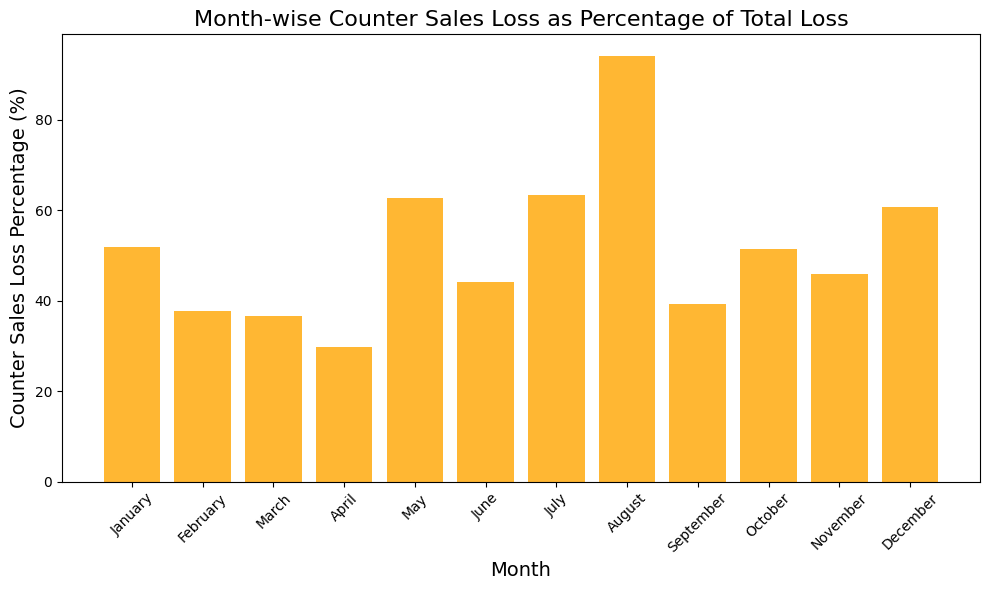

In [9]:
# Ensure the Invoice_Date column is in datetime format
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'])

# Extract month names
df['Month'] = df['Invoice_Date'].dt.strftime('%B')

# Filter rows where Job_Card_No is "Counter Sales"
counter_sales_data = df[df['Job_Card_No'].str.strip() == 'Counter Sales']

# Define a function to calculate loss (only consider negative values as loss)
def calculate_loss(row):
    loss = row['SellingPrice'] - row['Buying_Price']
    return loss if loss < 0 else 0

# Apply the loss calculation to the entire DataFrame
df['Loss'] = df.apply(calculate_loss, axis=1)
counter_sales_data['Loss'] = counter_sales_data.apply(calculate_loss, axis=1)

# Group by Month and calculate total loss
total_loss_per_month = df.groupby('Month')['Loss'].sum().reset_index(name='Total_Loss')
counter_sales_loss_per_month = counter_sales_data.groupby('Month')['Loss'].sum().reset_index(name='Counter_Sales_Loss')

# Merge the two datasets on Month
merged_loss_data = pd.merge(total_loss_per_month, counter_sales_loss_per_month, on='Month', how='left')
merged_loss_data['Counter_Sales_Loss_Percentage'] = (
    (merged_loss_data['Counter_Sales_Loss'] / merged_loss_data['Total_Loss']) * 100
).fillna(0)  # Fill NaN with 0 for months without "Counter Sales" losses

# Sort by Month for better presentation
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
merged_loss_data['Month'] = pd.Categorical(merged_loss_data['Month'], categories=month_order, ordered=True)
merged_loss_data = merged_loss_data.sort_values('Month')

# Display the result
print(merged_loss_data)

# Plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(merged_loss_data['Month'], merged_loss_data['Counter_Sales_Loss_Percentage'], color='orange', alpha=0.8)
plt.title('Month-wise Counter Sales Loss as Percentage of Total Loss', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Counter Sales Loss Percentage (%)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Month-Wise Analysis: Counter Sales Loss and Rows Percentage

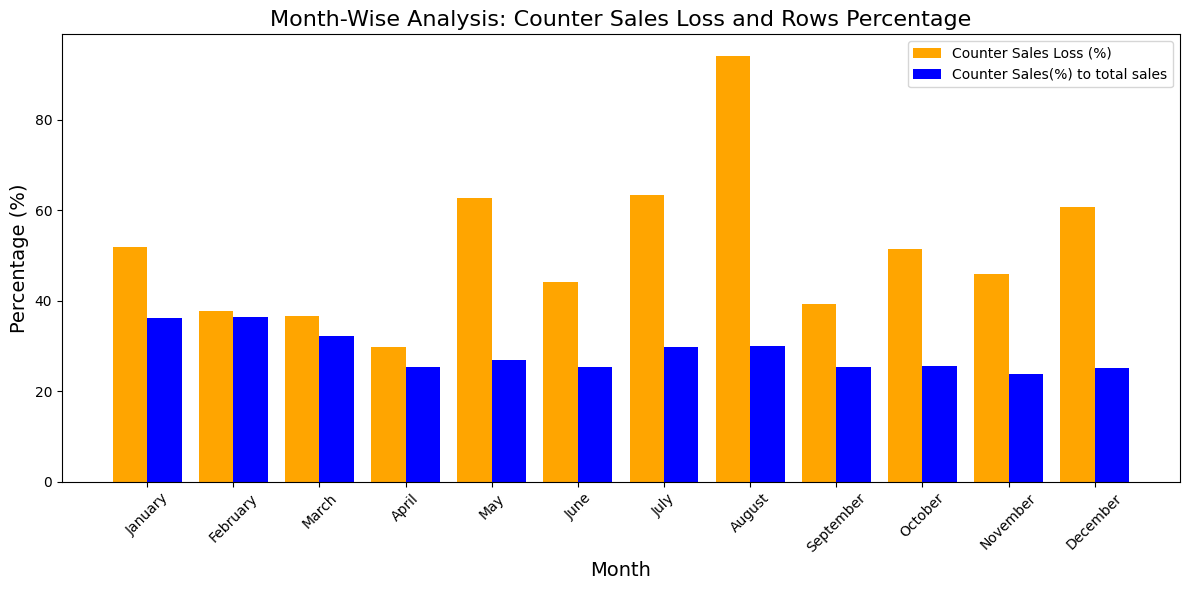

In [19]:
# Ensure the Invoice_Date column is in datetime format
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'])

# Extract the month name
df['Month'] = df['Invoice_Date'].dt.strftime('%B')

# Define the month order for sorting
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

# Calculate loss for all rows
df['Loss'] = df['SellingPrice'] - df['Buying_Price']
df['Loss'] = df['Loss'].apply(lambda x: x if x < 0 else 0)  # Only negative values are considered as loss

# Filter "Counter Sales" rows
counter_sales_df = df[df['Job_Card_No'] == 'Counter Sales']

# Month-wise calculations
results = []
for month in month_order:
    # Filter data for the current month
    month_data = df[df['Month'] == month]
    counter_sales_data = counter_sales_df[counter_sales_df['Month'] == month]
    
    if month_data.empty:
        continue

    # Total loss and Counter Sales loss
    total_loss = month_data['Loss'].sum()
    counter_sales_loss = counter_sales_data['Loss'].sum()

    # Total row count and Counter Sales row count
    total_rows = len(month_data)
    counter_sales_rows = len(counter_sales_data)

    # Calculate percentages
    loss_percentage = (counter_sales_loss / total_loss) * 100 if total_loss != 0 else 0
    row_percentage = (counter_sales_rows / total_rows) * 100 if total_rows != 0 else 0

    # Append results
    results.append({
        'Month': month,
        'Counter_Sales_Loss_Percentage': loss_percentage,
        'Counter_Sales_Row_Percentage': row_percentage
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Plot the side-by-side bar chart
x = range(len(results_df))
width = 0.4

plt.figure(figsize=(12, 6))
plt.bar(x, results_df['Counter_Sales_Loss_Percentage'], width=width, label='Counter Sales Loss (%)', color='orange')
plt.bar([i + width for i in x], results_df['Counter_Sales_Row_Percentage'], width=width, label='Counter Sales(%) to total sales', color='blue')
plt.xticks([i + width / 2 for i in x], results_df['Month'], rotation=45)
plt.title('Month-Wise Analysis: Counter Sales Loss and Rows Percentage', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

Top 10 Product Names Contributing profit or loss to the all rows of counter sales

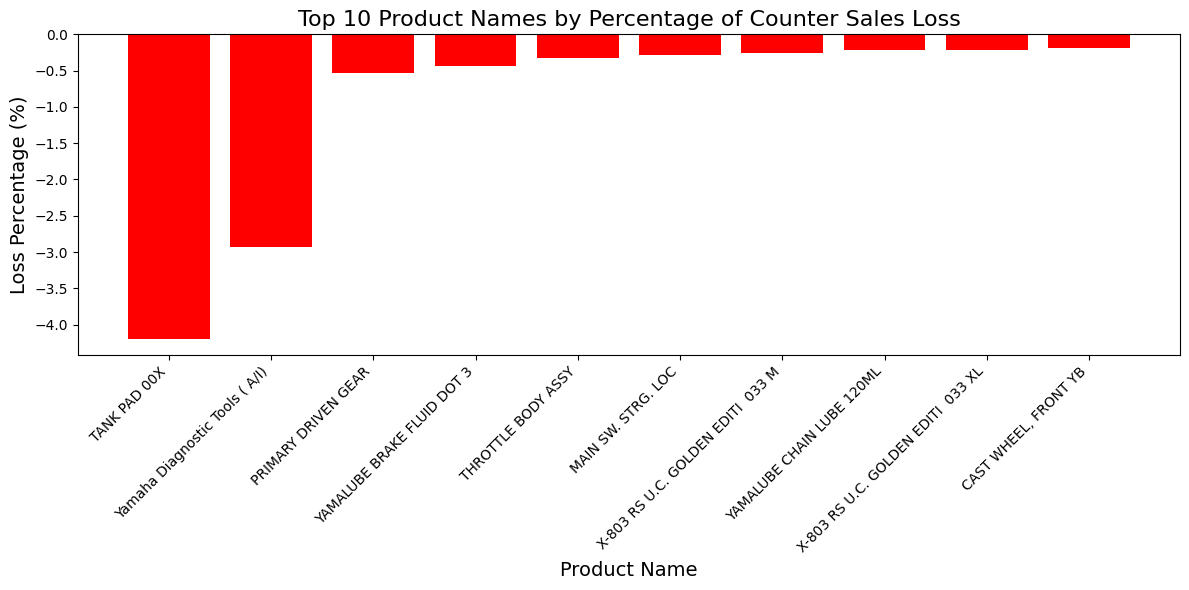


Top 10 Product Names Contributing to Counter Sales Loss (Percentage):
                            Product_Name  Profit_Percentage
2050                        TANK PAD 00X          -4.201536
2219      Yamaha Diagnostic Tools ( A/I)          -2.929765
1725                 PRIMARY DRIVEN GEAR          -0.530335
2201          YAMALUBE BRAKE FLUID DOT 3          -0.436419
2101                  THROTTLE BODY ASSY          -0.323425
1008                  MAIN SW. STRG. LOC          -0.284708
2194   X-803 RS U.C. GOLDEN EDITI  033 M          -0.251690
2205           YAMALUBE CHAIN LUBE 120ML          -0.215451
2195  X-803 RS U.C. GOLDEN EDITI  033 XL          -0.211311
263                 CAST WHEEL, FRONT YB          -0.184599


In [11]:
# Ensure the Invoice_Date column is in datetime format
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'])

# Calculate profit (or loss) for all rows
df['Profit'] = df['SellingPrice'] - df['Buying_Price']

# Filter only rows with "Counter Sales"
counter_sales_df = df[df['Job_Card_No'] == 'Counter Sales']

# Group by Product_Name and calculate total profit for Counter Sales
product_profit = counter_sales_df.groupby('Product_Name')['Profit'].sum().reset_index()

# Calculate the percentage contribution of each product's profit to the total profit
total_profit = product_profit['Profit'].sum()
product_profit['Profit_Percentage'] = (product_profit['Profit'] / total_profit) * 100

# Sort by profit percentage (ascending to show maximum loss products first)
top_loss_products = product_profit.sort_values('Profit_Percentage').head(10)

# Plot the top 10 products with maximum loss
plt.figure(figsize=(12, 6))
plt.bar(top_loss_products['Product_Name'], top_loss_products['Profit_Percentage'], color='red')
plt.title('Top 10 Product Names by Percentage of Counter Sales Loss', fontsize=16)
plt.xlabel('Product Name', fontsize=14)
plt.ylabel('Loss Percentage (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display the results in the terminal
print("\nTop 10 Product Names Contributing to Counter Sales Loss (Percentage):")
print(top_loss_products[['Product_Name', 'Profit_Percentage']])

Per invoice loss of coutner sales and non counter sales product ( top 10 products)

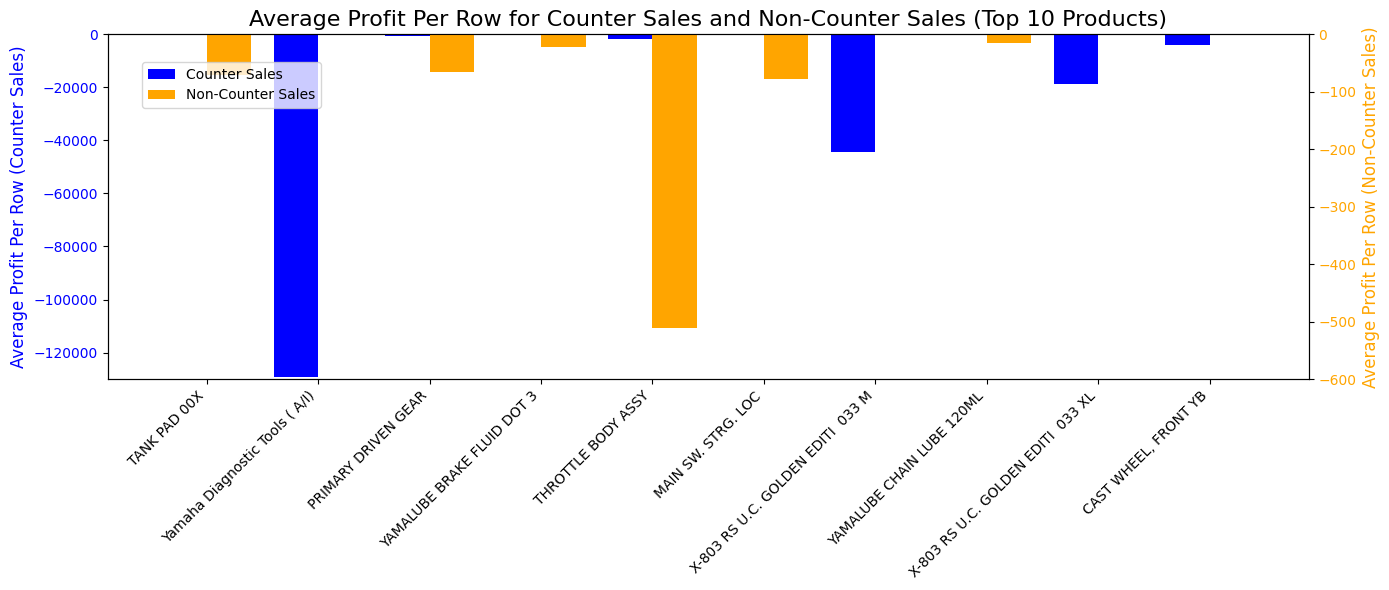


Average Profit Per Row for Counter Sales and Non-Counter Sales (Top 10 Products):
                         Product_Name  Avg_Profit_CounterSales  \
0                        TANK PAD 00X               -77.308672   
1      Yamaha Diagnostic Tools ( A/I)           -129150.000000   
2                 PRIMARY DRIVEN GEAR              -500.069519   
3          YAMALUBE BRAKE FLUID DOT 3               -35.825419   
4                  THROTTLE BODY ASSY             -1728.151515   
5                  MAIN SW. STRG. LOC              -221.154185   
6   X-803 RS U.C. GOLDEN EDITI  033 M            -44380.000000   
7           YAMALUBE CHAIN LUBE 120ML               -14.628417   
8  X-803 RS U.C. GOLDEN EDITI  033 XL            -18630.000000   
9                CAST WHEEL, FRONT YB             -4068.750000   

   Avg_Profit_NonCounterSales  
0                  -70.205132  
1                    0.000000  
2                  -66.026619  
3                  -22.339604  
4                 -510.633333 

In [12]:
# Ensure the Invoice_Date column is in datetime format
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'])

# Calculate profit for all rows
df['Profit'] = df['SellingPrice'] - df['Buying_Price']

# Filter for Counter Sales and non-Counter Sales rows
counter_sales_df = df[df['Job_Card_No'] == 'Counter Sales']
non_counter_sales_df = df[df['Job_Card_No'] != 'Counter Sales']

# Get the top 10 products with the highest loss percentage (as in the previous step)
product_profit = counter_sales_df.groupby('Product_Name')['Profit'].sum().reset_index()
total_profit = product_profit['Profit'].sum()
product_profit['Profit_Percentage'] = (product_profit['Profit'] / total_profit) * 100
top_10_products = product_profit.sort_values('Profit_Percentage').head(10)['Product_Name']

# Calculate average profit per row for Counter Sales and non-Counter Sales
counter_sales_avg_profit = counter_sales_df[counter_sales_df['Product_Name'].isin(top_10_products)] \
    .groupby('Product_Name').apply(lambda x: x['Profit'].sum() / len(x)).reset_index(name='Avg_Profit')

non_counter_sales_avg_profit = non_counter_sales_df[non_counter_sales_df['Product_Name'].isin(top_10_products)] \
    .groupby('Product_Name').apply(lambda x: x['Profit'].sum() / len(x)).reset_index(name='Avg_Profit')

# Ensure both DataFrames have all top 10 products
counter_sales_avg_profit = counter_sales_avg_profit.set_index('Product_Name').reindex(top_10_products).fillna(0).reset_index()
non_counter_sales_avg_profit = non_counter_sales_avg_profit.set_index('Product_Name').reindex(top_10_products).fillna(0).reset_index()

# Merge the results for easy plotting
avg_profit_df = pd.merge(counter_sales_avg_profit, non_counter_sales_avg_profit, on='Product_Name', suffixes=('_CounterSales', '_NonCounterSales'))

# Plotting the results
x = range(len(top_10_products))
width = 0.4  # Width of the bars

fig, ax1 = plt.subplots(figsize=(14, 6))

# Counter Sales bars (left y-axis)
ax1.bar([i - width / 2 for i in x], avg_profit_df['Avg_Profit_CounterSales'], width=width, color='blue', label='Counter Sales')
ax1.set_ylabel('Average Profit Per Row (Counter Sales)', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(-130000, 0)  # Set limits for the left y-axis

# Non-Counter Sales bars (right y-axis)
ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
ax2.bar([i + width / 2 for i in x], avg_profit_df['Avg_Profit_NonCounterSales'], width=width, color='orange', label='Non-Counter Sales')
ax2.set_ylabel('Average Profit Per Row (Non-Counter Sales)', fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim(-600, 0)  # Set limits for the right y-axis

# Set x-axis labels and title
ax1.set_xticks(x)
ax1.set_xticklabels(avg_profit_df['Product_Name'], rotation=45, ha='right')
plt.title('Average Profit Per Row for Counter Sales and Non-Counter Sales (Top 10 Products)', fontsize=16)
plt.xlabel('Product Name', fontsize=14)

# Add a legend
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.tight_layout()
plt.show()

# Display the results in the terminal
print("\nAverage Profit Per Row for Counter Sales and Non-Counter Sales (Top 10 Products):")
print(avg_profit_df)

3 most sold products per services

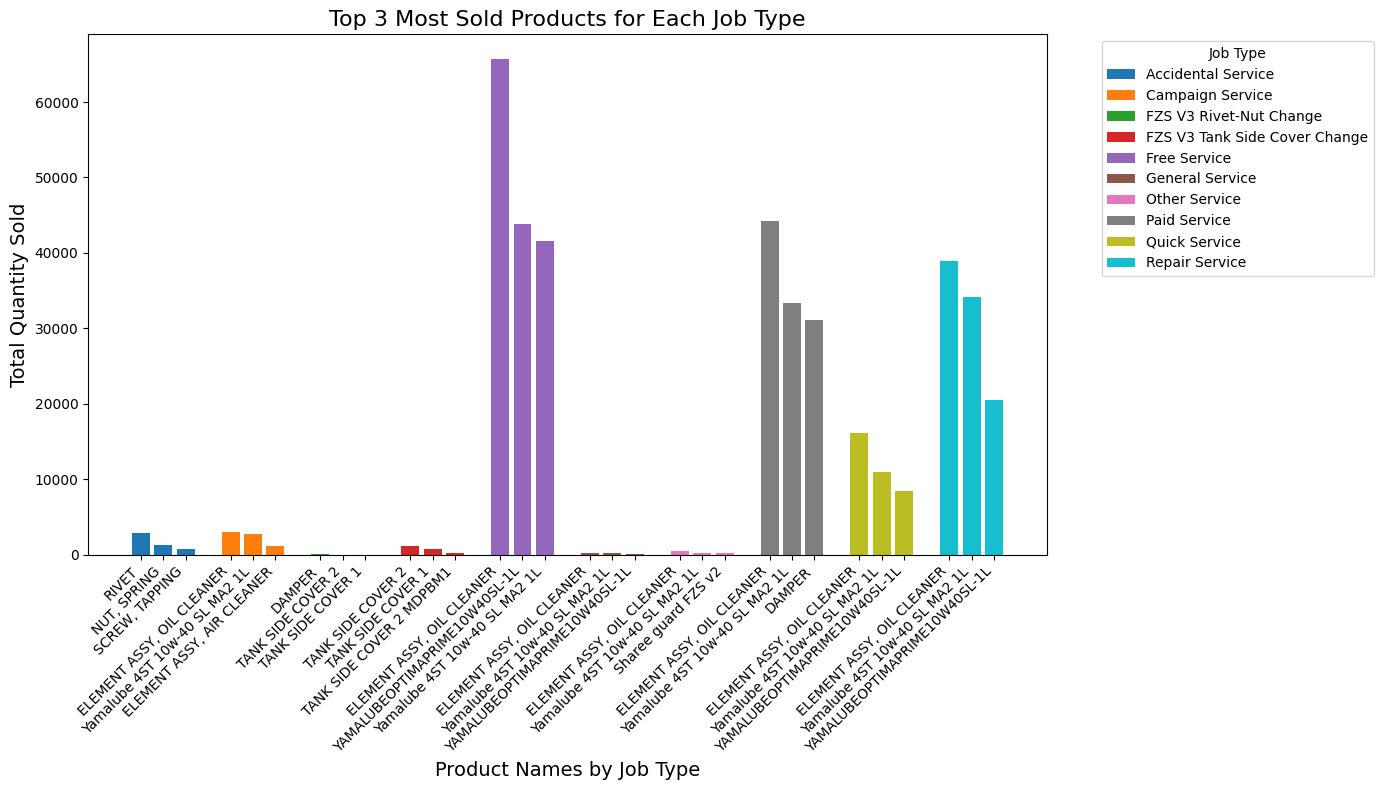

Top 3 Most Sold Products for Each 'Job_Type':
                         Job_Type                   Product_Name  Quantity
0              Accidental Service                          RIVET      2822
1              Accidental Service                    NUT, SPRING      1304
2              Accidental Service                 SCREW, TAPPING       788
3                Campaign Service      ELEMENT ASSY, OIL CLEANER      3030
4                Campaign Service  Yamalube 4ST 10w-40 SL MA2 1L      2750
5                Campaign Service      ELEMENT ASSY, AIR CLEANER      1194
6         FZS V3 Rivet-Nut Change                         DAMPER         6
7         FZS V3 Rivet-Nut Change              TANK SIDE COVER 2         4
8         FZS V3 Rivet-Nut Change              TANK SIDE COVER 1         3
9   FZS V3 Tank Side Cover Change              TANK SIDE COVER 2      1092
10  FZS V3 Tank Side Cover Change              TANK SIDE COVER 1       754
11  FZS V3 Tank Side Cover Change       TANK SIDE COVE

In [13]:
# Ensure the Invoice_Date column is in datetime format
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'])

# Group data by 'Job_Type' and 'Product_Name' to calculate total quantity sold
job_type_product_sales = df.groupby(['Job_Type', 'Product_Name'])['Quantity'].sum().reset_index()

# Get the top 3 products for each 'Job_Type'
top_products_per_job_type = job_type_product_sales.groupby('Job_Type').apply(
    lambda x: x.nlargest(3, 'Quantity')).reset_index(drop=True)

# Plotting the results
fig, ax = plt.subplots(figsize=(14, 8))

# Create a bar for each Job_Type
x_offset = 0  # To position bars for different Job_Types
bar_positions = []  # To store bar positions for custom ticks
bar_labels = []  # To store corresponding Job_Type and Product_Name labels

for idx, job_type in enumerate(top_products_per_job_type['Job_Type'].unique()):
    job_type_data = top_products_per_job_type[top_products_per_job_type['Job_Type'] == job_type]
    x_positions = range(x_offset, x_offset + len(job_type_data))
    bar_positions.extend(x_positions)
    bar_labels.extend(job_type_data['Product_Name'])
    ax.bar(x_positions, job_type_data['Quantity'], label=job_type)
    x_offset += len(job_type_data) + 1  # Add gap between groups

# Formatting the plot
ax.set_title('Top 3 Most Sold Products for Each Job Type', fontsize=16)
ax.set_xlabel('Product Names by Job Type', fontsize=14)
ax.set_ylabel('Total Quantity Sold', fontsize=14)
ax.set_xticks(bar_positions)
ax.set_xticklabels(bar_labels, rotation=45, ha='right', fontsize=10)
ax.legend(title='Job Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Display the results in the terminal
print("Top 3 Most Sold Products for Each 'Job_Type':")
print(top_products_per_job_type)

5 customers service time taking

In [14]:
# Ensure the Invoice_Date column is in datetime format
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'])

# Input customer names
customers = ["MD.ABDUR RASHID", "MD. NURZZAMAN", "MOHAMMAD AZIZUL HAKIM MOTIN", "MD.ZAHANGIR ALAM", "MD. MANIK UDDIN"]

# Initialize a DataFrame to store all results
results_table = pd.DataFrame()

# Loop through each customer
for customer in customers:
    # Filter data for the specific customer
    customer_data = df[df['Customer_Name'] == customer]
    
    if customer_data.empty:
        continue
    
    # Sort data by Invoice_Date
    customer_data = customer_data.sort_values(by='Invoice_Date')
    
    # Calculate the days between activities
    customer_data['Days_Since_Last_Job'] = customer_data['Invoice_Date'].diff().dt.days
    
    # Add customer name to the DataFrame
    customer_data['Customer_Name'] = customer
    
    # Select relevant columns for the table
    customer_data = customer_data[['Customer_Name', 'Invoice_Date', 'Days_Since_Last_Job', 'Job_Type']]
    
    # Append to results
    results_table = pd.concat([results_table, customer_data])

# Reset index for cleaner table
results_table.reset_index(drop=True, inplace=True)

# Display the results in a well-formatted table
print("\nCustomer Job Type Analysis:")
print(results_table.to_string(index=False))


Customer Job Type Analysis:
              Customer_Name Invoice_Date  Days_Since_Last_Job         Job_Type
            MD.ABDUR RASHID   2024-01-04                  NaN     Paid Service
            MD.ABDUR RASHID   2024-01-18                 14.0   Repair Service
            MD.ABDUR RASHID   2024-02-10                 23.0   Repair Service
            MD.ABDUR RASHID   2024-02-15                  5.0     Free Service
            MD.ABDUR RASHID   2024-02-18                  3.0   Repair Service
            MD.ABDUR RASHID   2024-02-18                  0.0   Repair Service
            MD.ABDUR RASHID   2024-02-18                  0.0   Repair Service
            MD.ABDUR RASHID   2024-02-18                  0.0   Repair Service
            MD.ABDUR RASHID   2024-02-18                  0.0   Repair Service
            MD.ABDUR RASHID   2024-03-04                 15.0   Repair Service
            MD.ABDUR RASHID   2024-03-13                  9.0     Free Service
            MD.ABDUR RA

In [15]:
# Ensure there are no leading or trailing spaces in the column name
df.rename(columns=lambda x: x.strip(), inplace=True)

# Get the unique values in the "Job_Type" column
unique_job_types = df['Job_Type'].unique()

# Display the unique values
print("Unique values in 'Job_Type':")
for job_type in unique_job_types:
    print(job_type)


Unique values in 'Job_Type':
Repair Service
nan
Free Service
Paid Service
Quick Service
FZS V3 Tank Side Cover Change
Other Service
Accidental Service
Campaign Service
General Service
FZS V3 Rivet-Nut Change


Top 50 Products Ranked by Quantity and Discount Percentage

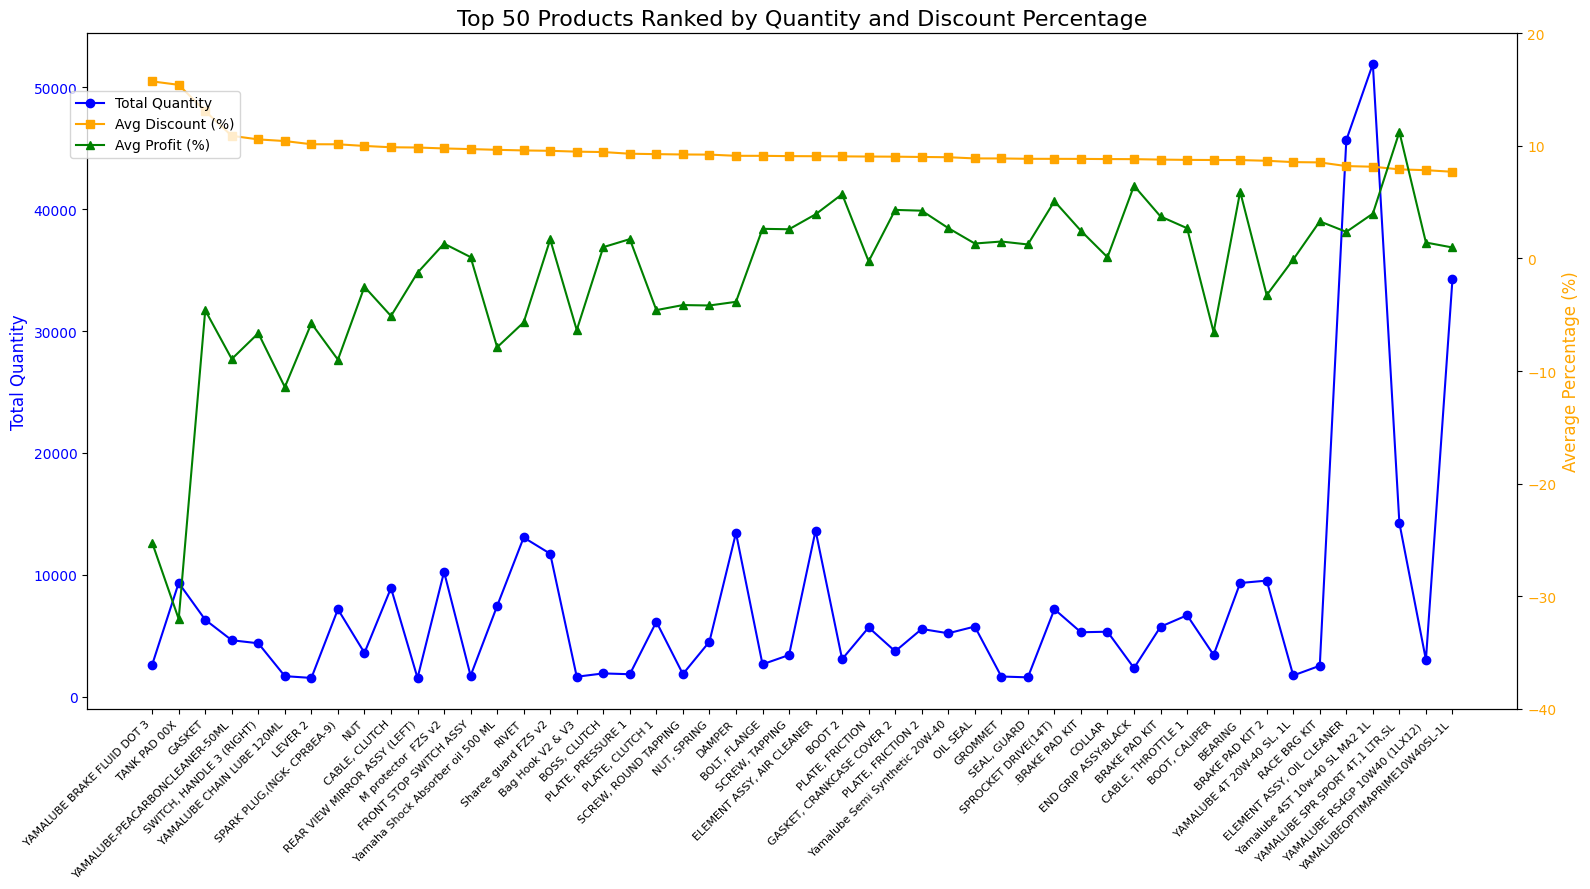


Top 50 Products Ranked by Quantity and Discount Percentage:
                          Product_Name  Total_Quantity  \
1762        YAMALUBE BRAKE FLUID DOT 3            2625   
1643                      TANK PAD 00X            9342   
599                             GASKET            6314   
1775    YAMALUBE-PEACARBONCLEANER-50ML            4635   
1633          SWITCH, HANDLE 3 (RIGHT)            4385   
1766         YAMALUBE CHAIN LUBE 120ML            1689   
758                            LEVER 2            1543   
1542        SPARK PLUG,(NGK- CPR8EA-9)            7175   
1182                               NUT            3599   
168                      CABLE, CLUTCH            8920   
1415      REAR VIEW MIRROR ASSY (LEFT)            1539   
775                M protector  FZS v2           10246   
581             FRONT STOP SWITCH ASSY            1723   
1779  Yamaha Shock Absorber oil 500 ML            7447   
1434                             RIVET           13065   
1639       

In [16]:
# Ensure correct column names and calculations
df['Discount_Percentage'] = ((df['Discount'] + df['AffiliatorDiscount']) / 
                             (df['Discount'] + df['AffiliatorDiscount'] + df['SellingPrice'])) * 100
df['Profit_Percentage'] = ((df['SellingPrice'] - df['Buying_Price']) / df['Buying_Price']) * 100

# Filter rows where Discount > 0
discounted_products = df[df['Discount'] > 0]

# Group by Product_Name and calculate total quantity, average discount percentage, and average profit percentage
product_stats = discounted_products.groupby('Product_Name').agg(
    Total_Quantity=('Quantity', 'sum'),
    Avg_Discount_Percentage=('Discount_Percentage', 'mean'),
    Avg_Profit_Percentage=('Profit_Percentage', 'mean')
).reset_index()

# Step 1: Rank by Total Quantity (Top 50 products)
top_50_products = product_stats.nlargest(50, 'Total_Quantity')

# Step 2: Rank the selected products by Avg Discount Percentage (High to Low)
ranked_products = top_50_products.sort_values(by='Avg_Discount_Percentage', ascending=False)

# Plotting
fig, ax1 = plt.subplots(figsize=(16, 9))

# Line for total quantity (left y-axis)
ax1.plot(ranked_products['Product_Name'], ranked_products['Total_Quantity'], color='blue', marker='o', label='Total Quantity')
ax1.set_ylabel('Total Quantity', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(len(ranked_products['Product_Name'])))
ax1.set_xticklabels(ranked_products['Product_Name'], rotation=45, ha='right', fontsize=8)

# Line for average discount percentage (right y-axis)
ax2 = ax1.twinx()
ax2.plot(ranked_products['Product_Name'], ranked_products['Avg_Discount_Percentage'], color='orange', marker='s', label='Avg Discount (%)')
ax2.plot(ranked_products['Product_Name'], ranked_products['Avg_Profit_Percentage'], color='green', marker='^', label='Avg Profit (%)')
ax2.set_ylabel('Average Percentage (%)', fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim(-40, 20)  # Set the range for percentage axes

# Title and layout
plt.title('Top 50 Products Ranked by Quantity and Discount Percentage', fontsize=16)
fig.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(0.1, 0.9), fontsize=10)
plt.show()

# Display results in the terminal
print("\nTop 50 Products Ranked by Quantity and Discount Percentage:")
print(ranked_products)


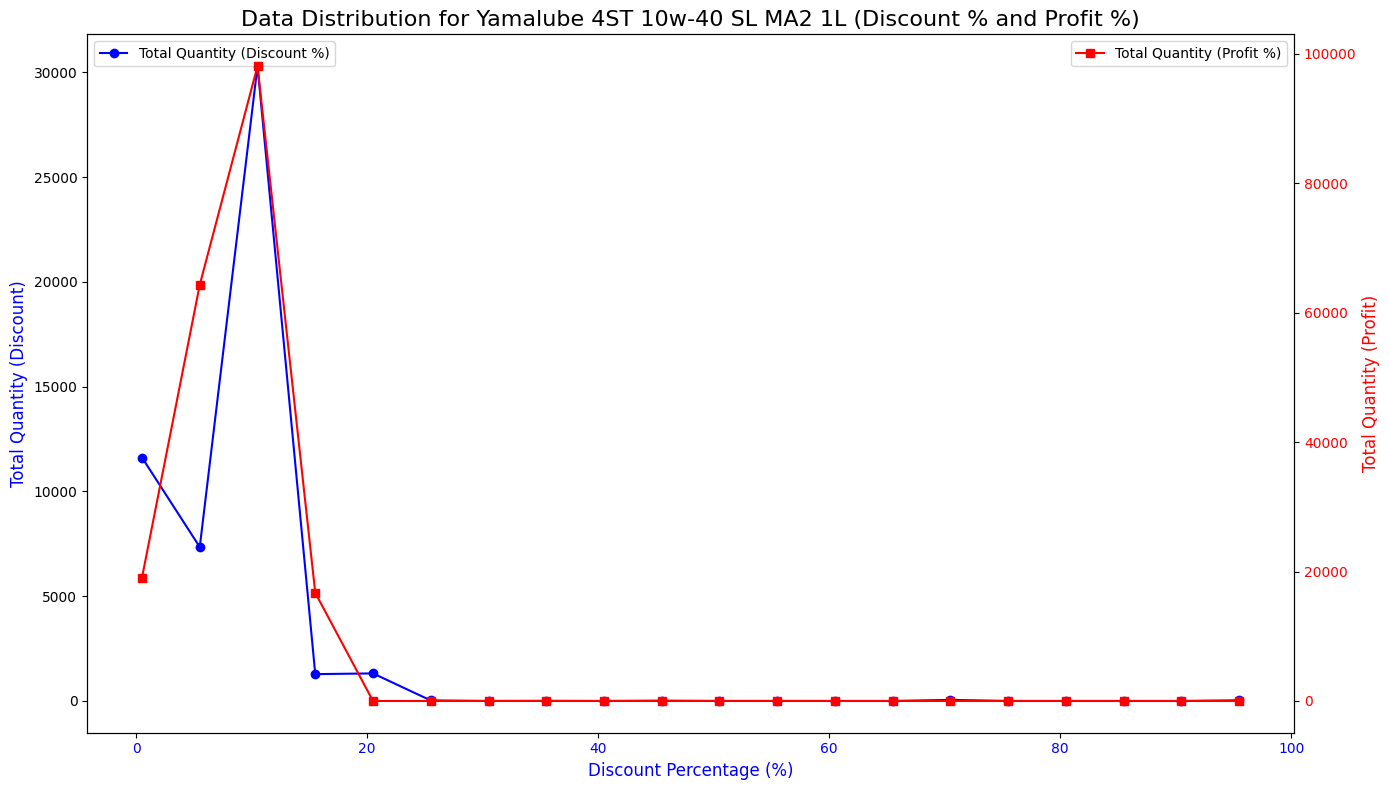

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate discount percentage
def calculate_discount_percentage(row):
    denominator = row['Discount'] + row['AffiliatorDiscount'] + row['SellingPrice']
    return ((row['Discount'] + row['AffiliatorDiscount']) / denominator) * 100 if denominator != 0 else 0

# Function to calculate profit percentage
def calculate_profit_percentage(row):
    return ((row['SellingPrice'] - row['Buying_Price']) / row['Buying_Price']) * 100 if row['Buying_Price'] != 0 else 0

# Add new columns for discount and profit percentages
df['Discount_Percentage'] = df.apply(calculate_discount_percentage, axis=1)
df['Profit_Percentage'] = df.apply(calculate_profit_percentage, axis=1)

# Define function to plot data distribution graph
def plot_data_distribution(product_name):
    # Filter data for the specified product
    product_data = df[df['Product_Name'] == product_name]

    if product_data.empty:
        print(f"No data found for Product: {product_name}")
        return

    # Define bins for discount and profit percentages (0-100 with step of 1)
    bins = np.arange(0, 101, 5)

    # Group data by bins and calculate total quantity for each bin
    discount_distribution = product_data.groupby(pd.cut(product_data['Discount_Percentage'], bins=bins))['Quantity'].sum()
    profit_distribution = product_data.groupby(pd.cut(product_data['Profit_Percentage'], bins=bins))['Quantity'].sum()

    # Prepare x-axis labels (midpoints of bins)
    bin_centers = bins[:-1] + 0.5

    # Plotting
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plot total quantity vs discount percentage
    ax1.plot(bin_centers, discount_distribution, label='Total Quantity (Discount %)', color='blue', marker='o')
    ax1.set_xlabel('Discount Percentage (%)', fontsize=12, color='blue')
    ax1.set_ylabel('Total Quantity (Discount)', fontsize=12, color='blue')
    ax1.tick_params(axis='x', labelcolor='blue')

    # Plot total quantity vs profit percentage on secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(bin_centers, profit_distribution, label='Total Quantity (Profit %)', color='red', marker='s')
    ax2.set_ylabel('Total Quantity (Profit)', fontsize=12, color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Title and legend
    plt.title(f'Data Distribution for {product_name} (Discount % and Profit %)', fontsize=16)
    fig.tight_layout()
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Show plot
    plt.show()

# Input product name
product_name_input = input("Enter Product Name for Distribution Graph: ")
plot_data_distribution(product_name_input)

